### ConvLSTM 101
- The aim of this notebook is to explicitly code up a user-friendlly ConvLSTM based on the paper - https://arxiv.org/abs/1506.04214

In [70]:
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms as transforms

# seqmod package imports
from src.utils import set_seed, add_metric_plot
from src.dataset import StormImageSequencedDataset

In [71]:
SEED = 42
set_seed(42)

print(f"SEED = {SEED}")

SEED = 42


In [72]:
DEVICE = "cpu"
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    DEVICE = "cuda"
else:
    print("No GPU available!")

DEVICE

No GPU available!


'cpu'

In [73]:
##### DATASET INPUTS #####
IMAGE_ROOT_DIR = "../data/"
STORM_NAME = "gkf"
INPUT_SEQUENCE_LENGTH = 4
TARGET_SEQUENCE_LENGTH = 1
DATA_SPLIT = (0.8, 0.2)

# debug info
print("\t\t#### DATASET INFO ####\n")
print(f"\t--> IMAGE ROOT DIR = {IMAGE_ROOT_DIR}")
print(f"\t--> STORM NAME = {STORM_NAME}")
print(f"\t--> INPUT SEQUENCE LENGTH = {INPUT_SEQUENCE_LENGTH}")
print(f"\t--> TARGET SEQUENCE LENGTH = {TARGET_SEQUENCE_LENGTH}")
print(f"\t--> DATA SPLIT = {DATA_SPLIT}")


##### DATALOADER INPUTS #####
BATCH_SIZE = 4
NUM_WORKERS = 0

print("\n\n\t\t#### DATALOADER INFO ####\n")
print(f"\t--> BATCH SIZE = {BATCH_SIZE}")
print(f"\t--> NUM WORKERS {NUM_WORKERS}")

		#### DATASET INFO ####

	--> IMAGE ROOT DIR = ../data/
	--> STORM NAME = gkf
	--> INPUT SEQUENCE LENGTH = 4
	--> TARGET SEQUENCE LENGTH = 1
	--> DATA SPLIT = (0.8, 0.2)


		#### DATALOADER INFO ####

	--> BATCH SIZE = 4
	--> NUM WORKERS 0


In [74]:
# transforms applied
DESIRED_IMAGE_DIMS = (366, 366)
print(f"DESIRED DIMS (Resizing) = {DESIRED_IMAGE_DIMS}\n")

transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize(DESIRED_IMAGE_DIMS, antialias=True),
    ]
)

transform

DESIRED DIMS (Resizing) = (366, 366)



Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(366, 366), interpolation=bilinear, max_size=None, antialias=True)
)

Text(0.5, 1.0, '1 image (366, 366) idx:0')

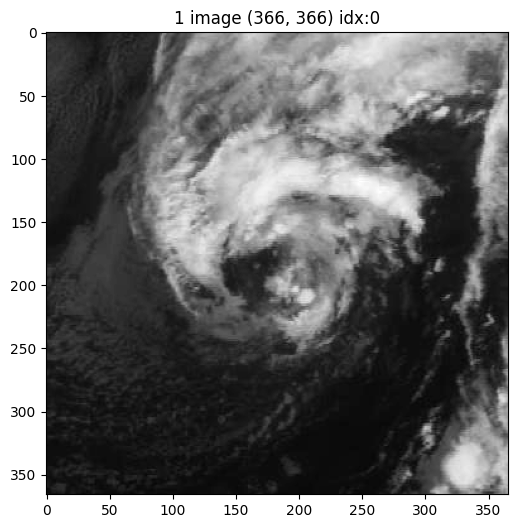

In [75]:
dummy = StormImageSequencedDataset(
    image_root_dir=IMAGE_ROOT_DIR,
    image_file_type="jpg",
    storm_name=STORM_NAME,
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    target_sequence_length=TARGET_SEQUENCE_LENGTH,
    data_split="train",
    split_pct=DATA_SPLIT,  # (train, val)
    transform=transform,
)


# run a pass through the dataset and plot a storm.
idx, img_sequence_num = 0, 0
img_sequence, target = dummy.__getitem__(idx)

# plot storm
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_sequence[0, 0, :, :], cmap="gray")
ax.set_title(f"{img_sequence_num+1} image {DESIRED_IMAGE_DIMS} idx:{idx}")

In [76]:
### Create datasets
train_dataset = StormImageSequencedDataset(
    image_root_dir=IMAGE_ROOT_DIR,
    image_file_type="jpg",
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    target_sequence_length=TARGET_SEQUENCE_LENGTH,
    storm_name=STORM_NAME,
    data_split="train",
    split_pct=DATA_SPLIT,  # (train, val)
    transform=transform,
)

val_dataset = StormImageSequencedDataset(
    image_root_dir=IMAGE_ROOT_DIR,
    image_file_type="jpg",
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    target_sequence_length=TARGET_SEQUENCE_LENGTH,
    storm_name=STORM_NAME,
    data_split="val",
    split_pct=DATA_SPLIT,  # (train, val)
    transform=transform,
)

print("\n\n\t\t#### TENSOR INFO ####\n")
print(
    f"\t --> Train Dataset: {train_dataset.__len__()} | dims: {train_dataset.data.shape}"
)
print(
    f"\t --> Validation Dataset: {val_dataset.__len__()} | dims: {val_dataset.data.shape} "
)



		#### TENSOR INFO ####

	 --> Train Dataset: 268 | dims: (268, 5)
	 --> Validation Dataset: 68 | dims: (68, 5) 


In [77]:
# Create data loaders
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

train_loader.dataset.__len__(), val_loader.dataset.__len__()

(268, 68)

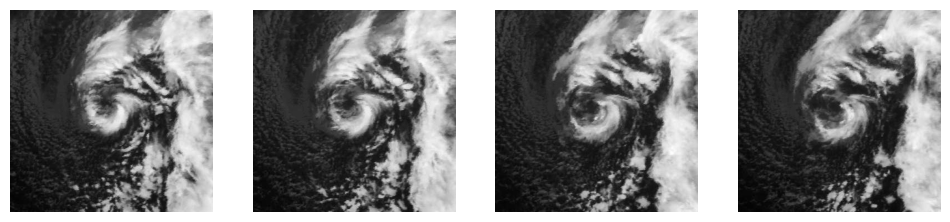

In [78]:
# plot a batch
train_batch = next(iter(train_loader))
img_seq, target_seq = train_batch
_batch_num = 1

# plot input sequence
_, axs = plt.subplots(nrows=1, ncols=INPUT_SEQUENCE_LENGTH, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(img_seq[_batch_num, :, 0, :, :], axs):
    ax.imshow(img.squeeze(0), cmap="gray")
    ax.axis("off")

plt.show()

In [79]:
from collections import OrderedDict
from typing import List, Tuple


class ConvLSTMCell(nn.Module):
    """ConvLSTMCell module.

    Parameters
    ----------
    input_channels : Tuple[int, int, int]
        The number of channels (C, _, _) of each image in the input image sequence.
    input_height : Tuple[int, int, int]
        The height (_, H, _) of each image in the input image sequence.
    input_width : Tuple[int, int, int]
        The width (_, _, W) of each image in the input image sequence.
    hidden_channels:  int
        The number of hidden channels. This is the number of output channels in the convolution(i, h).
    kernel_size: Tuple[int]
        The size of the kernel to perform the convolutional operations.
    apply_batchnorm : bool, optional
        If `True`, a batchnorm will be applied after each convolution(i, h) in each ConvLSTM cell. Default is `True`.
    bias : bool, optional
        If `True`, the LSTM layers will use bias weights. Default is `True`.
    device : str
        The device (CPU or GPU) on which the model will be run. Should be specified as a string ('cpu' or 'cuda'). Default is 'cpu'.
    _print : bool, optional
        If `True`, enables printing of model-related information for debugging or logging. Default is `False`.
    """

    def __init__(
        self,
        input_channels: int,
        input_height: int,
        input_width: int,
        hidden_channels: int,
        kernel_size: int,
        apply_batchnorm: bool = True,
        bias: bool = True,
        device: str = "cpu",
        _print: bool = False,
    ):
        """Initialisation."""
        super(ConvLSTMCell, self).__init__()

        # seeded for reproducibility.
        set_seed(SEED)

        # inputs.
        self.input_channels = input_channels  # input_channels is equivalent to self.input_size in LSTM (how many features ~ how many channels...)
        self.input_height = input_height
        self.input_width = input_width
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.bias = bias
        self.apply_batchnorm = apply_batchnorm
        self.device = device
        self.print = _print

        # debug info
        if self.print:
            print("\n------ CONVOLUTION DIMS -------")
            print(
                f"Conv input: {(self.input_channels + self.hidden_channels)} [i: {self.input_channels}, h: {self.hidden_channels}]"
            )
            print(f"Conv output: {4 * self.hidden_channels}")

        if self.apply_batchnorm:
            self.conv_input_and_hidden = nn.Sequential(
                OrderedDict(
                    [
                        (
                            "conv_layer",
                            nn.Conv2d(
                                in_channels=(
                                    self.input_channels + self.hidden_channels
                                ),
                                out_channels=(4 * self.hidden_channels),
                                kernel_size=self.kernel_size,
                                padding=(1, 1),
                                bias=self.bias,
                            ),
                        ),
                        (
                            "batchnorm",
                            nn.BatchNorm2d(num_features=(4 * self.hidden_channels)),
                        ),
                    ]
                )
            )
        else:
            # no batch normalisation applied after convolution.
            self.conv_input_and_hidden = nn.Conv2d(
                in_channels=(self.input_channels + self.hidden_channels),
                out_channels=(4 * self.hidden_channels),
                kernel_size=self.kernel_size,
                padding=(1, 1),
                bias=self.bias,
            )

        # initialise the weights (and biases) of the self.conv_input_and_hidden convolution layer.
        self._initialise_parameters(layer=self.conv_input_and_hidden)

        # initialise the weights for Hadamard Products
        self.Wci, self.Wcf, self.Wco = self._init_hadamard_products_weights()

    def _initialise_parameters(self, layer):
        """Initialise the layer weights and biases with a unform dist [-std, std], where std = sqrt(1/hidden_channels).
        For the convolutional layer: number of weights = (out_channels, in_channels, *(kernel_size)), number of biases = (out_channels).

        Parameters
        ----------
        layer : torch.nn.Module
            The layer whose parameters are to be initialized. This should be a layer from a PyTorch model,
            such as a convolutional layer, that has weights and biases as its parameters.
        """
        std = 1 / np.sqrt(self.hidden_channels)
        for _, _param in enumerate(layer.parameters()):
            _param.data.uniform_(-std, std)

    def _init_hadamard_products_weights(self):
        """Initialise the weights used in the Hadamard Product details in - https://arxiv.org/abs/1506.04214.

        These are initialised w/ dims: (1, hidden_channels, H, W). The weights are initialised so that each cell
        within each layer shares the same Wci, Wcf, and Wco weights but these are distinct from those in other layers.
        There will be only 1 set of trainable Wci, Wcf and Wco per layer.
        """
        # TODO: do I need this to have dims: (batch_size, , , )
        Wci = torch.zeros(
            1,
            self.hidden_channels,
            self.input_height,
            self.input_width,
            requires_grad=True,
        ).to(self.device)
        Wcf = torch.zeros(
            1,
            self.hidden_channels,
            self.input_height,
            self.input_width,
            requires_grad=True,
        ).to(self.device)
        Wco = torch.zeros(
            1,
            self.hidden_channels,
            self.input_height,
            self.input_width,
            requires_grad=True,
        ).to(self.device)

        return Wci, Wcf, Wco

    def forward(self, i: torch.Tensor, h: torch.Tensor, c: torch.Tensor):
        """Forward pass through the ConvLSTM Cell.

        Parameters
        ----------
        i : torch.Tensor
            input image into ConvLSTM cell w/ dims: (batch_size, channels, height, width)
        h : torch.Tensor
            input hidden state into ConvLSTM cell w/ dims: (batch_size, channels, height, width)
        c : torch.Tensor
            input cell state into ConvLSTM cell w/ dims: (batch_size, channels, height, width)

        Returns
        -------
        h_t: torch.Tensor
            output hidden state w/ dims: (batch_size, channels, height, width)
        c_t: torch.Tensor
            output cell state w/ dims: (batch_size, channels, height, width)
        """
        if self.print:
            print("\n---------------------- ConvLSTM CELL ----------------------")
            print(f"Conv LSTM Cell Inputs:")
            print(f"\tinput channels = {i.size(1)} || {self.input_channels}")
            print(f"\thidden channels = {h.size(1)} || {self.hidden_channels}")
            print(f"\tcell state channels = {c.size(1)}\n")

        # bottom left of the LSTM cell (diagram). This is performing a convolution on the combined input i(t) with h(t-1)
        gates = self.conv_input_and_hidden(torch.cat([i, h], dim=1))

        input_gate, forget_gate, candidate_update, output_gate = gates.chunk(
            4, dim=1
        )  # separate the output into each of cell gate operations

        # apply the corresponding activations [details in - https://arxiv.org/abs/1506.04214]
        i_t = torch.sigmoid(
            input_gate + (self.Wci * c)
        )  # it = σ((Wxi * Xt + Whi * Ht−1) + (Wci o Ct−1) + bi)
        f_t = torch.sigmoid(
            forget_gate + (self.Wcf * c)
        )  # ft = σ((Wxf * Xt + Whf * Ht−1) + (Wcf o Ct−1) + bf)
        cd_t = (c * f_t) + (
            i_t * torch.tanh(candidate_update)
        )  # Ct = (ft o Ct−1) + (it o tanh((Wxc * Xt + Whc * Ht−1) + bc))
        o_t = torch.sigmoid(
            output_gate + (self.Wco * c)
        )  # ot = σ((Wxo * Xt + Who * Ht−1) + (Wco o Ct) + bo)

        if self.print:
            print("LSTM Cell Gate Outputs:")
            print(f"\tinput gate = {i_t.size()}")
            print(f"\tforget gate = {f_t.size()}")
            print(f"\tcandidate update = {cd_t.size()}")
            print(f"\toutput update = {o_t.size()}\n")

        # calculate the next cell state
        c_t = (f_t * c) + (i_t * cd_t)

        # calculate the next hidden state
        h_t = o_t * torch.tanh(c_t)

        if self.print:
            print("LSTM Cell Outputs:")
            print(f"\tc_t = {c_t.size()}")
            print(f"\th_t = {h_t.size()}")

        return h_t, c_t

In [80]:
class ConvLSTM(nn.Module):
    """ConvLSTM module.

    Parameters
    ----------
    input_sequence_length : int
        The length of the input image sequence. Determines how many ConvLSTM cells are in each layes - 1 cell per element in sequence.
    input_dims : Tuple[int, int, int]
        The (C, H, W) [number of channels, height, width] of each image in the input image sequence.
    hidden_channels:  List[int]
        A list of the number of channels for the convolutional output for each layer. There should be a hidden_channel values for each layer.
    output_channels:  int
        The desired number of channels in the convoled hidden outputs from the cells in the last layer.
    num_layers : int
        Number of stacked ConvLSTM layers.Each ConvLSTM layer, m will consist of n ConvLSTMCells where n = input seuqnce length.
    kernel_size: Tuple[int]
        The size of the kernel to perform the convolutional operations.
    apply_batchnorm : bool, optional
        If `True`, a batchnorm will be applied after each convolution(i, h) in each ConvLSTM cell. Default is `True`.
    bias : bool, optional
        If `True`, the LSTM layers will use bias weights. Default is `True`.
    device : str
        The device (CPU or GPU) on which the model will be run. Should be specified as a string ('cpu' or 'cuda'). Default is 'cpu'.
    _print : bool, optional
        If `False`, enables printing of model-related information for debugging or logging. Default is `False`.
    """

    def __init__(
        self,
        input_sequence_length: int,
        input_dims: Tuple[int, int, int],
        hidden_channels: List[int],
        output_channels: int,
        num_layers: int,
        kernel_size: Tuple[int],
        apply_batchnorm: bool = True,
        bias: bool = True,
        device: str = "cpu",
        _print: bool = True,
    ):
        """Initialisation."""
        super(ConvLSTM, self).__init__()

        set_seed(SEED)

        self.input_sequence_length = input_sequence_length
        self.input_dims = input_dims
        self.input_channels, self.input_height, self.input_width = input_dims
        self.hidden_channels = hidden_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias
        self.apply_batchnorm = apply_batchnorm
        self.device = device
        self.print = _print

        # create a list of lstm cell modules
        self.conv_lstm_cell_list = nn.ModuleList()

        assert len(self.hidden_channels) == self.num_layers

        # create each layer in the network
        for l in range(self.num_layers):
            if self.print:
                print(f"Adding ConvLSTM Cell (layer) {l}...")
            _cell = ConvLSTMCell(
                input_channels=(
                    self.input_channels if l == 0 else self.hidden_channels[l - 1]
                ),
                input_height=self.input_height,
                input_width=self.input_width,
                hidden_channels=self.hidden_channels[l],
                kernel_size=self.kernel_size,
                bias=self.bias,
                apply_batchnorm=self.apply_batchnorm,
                device=self.device,
                _print=self.print,
            )

            self.conv_lstm_cell_list.append(_cell)

        # create a final convolutional layer from hidden state to network output
        self.conv_hidden_to_output = nn.Conv2d(
            in_channels=self.hidden_channels[
                -1
            ],  # take the hidden channels from the last layer.
            out_channels=self.output_channels,
            kernel_size=self.kernel_size,
            padding=(1, 1),
            bias=self.bias,
        )

        # initilaise weights of the conv_hidden2output layer
        self._initialise_parameters(layer=self.conv_hidden_to_output)

    def _initialise_parameters(self, layer):
        """Initialise the layer weights and biases with a unform dist [-std, std], where std = sqrt(1/hidden_channels).
        For the convolutional layer: number of weights = (out_channels, in_channels, *(kernel_size)), number of biases = (out_channels).

        Parameters
        ----------
        layer : torch.nn.Module
            The layer whose parameters are to be initialized. This should be a layer from a PyTorch model,
            such as a convolutional layer, that has weights and biases as its parameters.
        """
        std = 1 / np.sqrt(self.hidden_channels[-1])
        for _, _param in enumerate(layer.parameters()):
            _param.data.uniform_(-std, std)

    def _init_hidden_and_cell_states(self, batch_size):
        """Initialise the _hidden_states and _cell_states that will go into the 1st ConvLSTM cells in each layer.

        _states are initialised to zero w/ dims: (batch_size, hidden_channels, input_image_height, input_image_width).
        The position of the _state in the list corresponds to the layer.
        """
        hs, cs = [], []
        for _layer in range(self.num_layers):
            if self.print:
                print(
                    f"Adding h, c states w/ dims: ({(batch_size, self.hidden_channels[_layer], self.input_height, self.input_width)}) @ layer {_layer}."
                )
            hs.append(
                torch.zeros(
                    batch_size,
                    self.hidden_channels[_layer],
                    self.input_height,
                    self.input_width,
                    requires_grad=False,
                ).to(self.device)
            )
            cs.append(
                torch.zeros(
                    batch_size,
                    self.hidden_channels[_layer],
                    self.input_height,
                    self.input_width,
                    requires_grad=False,
                ).to(self.device)
            )

        return hs, cs

    def forward(self, x: torch.Tensor, h0: torch.Tensor, c0: torch.Tensor):
        """Forward pass through the ConvLSTM.

        Parameters:
        ----------
        x : torch.Tensor
            The input image sequence to each cell in the 1st layer w/ dims: (batch_size, sequence_length, num_channels, height, width)
        h0 : torch.Tensor
            The input hidden states (for each layer) w/ dims: (batch_size, sequence_length, num_channels, height, width)
        c0 : torch.Tensor
            The input cell states (for each layer) w/ dims: (batch_size, sequence_length, num_channels, height, width)

        Returns
        -------
        torch.Tensor
            The output of each ConvLSTMCell in the last layer.

        Workflow:
        ---------
                                                output1                            output2                                outputN
                                                   ^                                  ^                                      ^
                                                   | (hN,1)                           | (hN,2)                               | (hN,n)
        LayerN:    (hN,0, cn,0)--> [(C(h2,1, hN,0)) ] -> (hn,1, cn,1) [(C(h2,2, hN,1)) ] -> (hn,2, cn,2) ... [(C(h2,n, hN,n)) ]
                                                   ^                                   ^                                      ^
                                                   | (h2,1)                            | (h2,2)                               | (h2,n)
        Layer2:   (h2,0, c2,0)--> [(C(h1,1, h2,0)).. ] -> (h2,1, c2,1) [(C(h1,2, h2,1)).. ] -> (h2,2, c2,2) ... [(C(h1,n, h2,2)).. ]
                                                 ^                                  ^                                     ^
                                                 | (h1,1)                           | (h1,2)                              | (h1,n)
        Layer1: (h1,0, c1,0) --> [(C(i1, h1,0))..  ] -> (h1,1, c1,1) [(C(i1, h1,0)..  ] -> (h1,2, c1,2) ... [C(iN, h1,2)..  ]
                                        ^                                   ^                                     ^
                                        |                                   |                                     |
                                      input1                               input2                               inputN
        """
        _hidden_states = []
        _cell_states = []
        for layer in range(self.num_layers):
            _hidden_states.append(h0[layer])
            _cell_states.append(c0[layer])

        _outputs = []
        for t in range(x.size(1)):  # loop over each element in the input sequence.
            for layer in range(self.num_layers):  # loop over each layer in the network.
                if layer == 0:
                    # each cell in the 1st layer takes in the raw element from the input sequence + hidden state and a cell state.
                    hidden_l, cell_l = self.conv_lstm_cell_list[layer](
                        i=x[:, t, :, :, :],
                        h=_hidden_states[layer],
                        c=_cell_states[layer],
                    )
                else:
                    # each cell in > 1st layer takes in 2 hidden states as input and hidden and a cell state.
                    hidden_l, cell_l = self.conv_lstm_cell_list[layer](
                        i=_hidden_states[layer - 1],
                        h=_hidden_states[layer],
                        c=_cell_states[layer],
                    )

                # update the hidden and cell states.
                _hidden_states[layer] = hidden_l
                _cell_states[layer] = cell_l

            # the output from each cell in the last layer.
            _outputs.append(hidden_l)

        assert len(_outputs) == self.input_sequence_length

        # apply a convolution from each output in the last layer to the desired number of channels
        output = torch.stack(
            [self.conv_hidden_to_output(_out) for _out in _outputs], dim=1
        )

        return output

In [81]:
class ConvLSTMModel(nn.Module):
    """Wrapper module for the ConvLSTM.

    Parameters
    ----------
    input_sequence_length : int
        The length of the input image sequence. Determines how many ConvLSTM cells are in each layes - 1 cell per element in sequence.
    output_sequence_length : int
        The desired length of the output image sequence. Return last output_sequence_length number of convolved hidden outputs from the last layer.
    input_dims : Tuple[int, int, int]
        The (C, H, W) [number of channels, height, width] of each image in the input image sequence.
    hidden_channels:  List[int]
        A list of the number of channels for the convolutional output for each layer. There should be a hidden_channel values for each layer.
    output_channels:  int
        The desired number of channels in the convoled hidden outputs from the cells in the last layer.
    num_layers : int
        Number of stacked ConvLSTM layers.Each ConvLSTM layer, m will consist of n ConvLSTMCells where n = input seuqnce length.
    kernel_size: Tuple[int]
        The size of the kernel to perform the convolutional operations.
    apply_batchnorm : bool, optional
        If `True`, a batchnorm will be applied after each convolution(i, h) in each ConvLSTM cell. Default is `True`.
    bias : bool, optional
        If `True`, the LSTM layers will use bias weights. Default is `True`.
    device : str
        The device (CPU or GPU) on which the model will be run. Should be specified as a string ('cpu' or 'cuda'). Default is 'cpu'.
    _print : bool, optional
        If `True`, enables printing of model-related information for debugging or logging. Default is `False`.
    """

    def __init__(
        self,
        input_sequence_length: int,
        output_sequence_length: int,
        input_dims: Tuple[int, int, int],
        hidden_channels: List[int],
        output_channels: int,
        num_layers: int,
        kernel_size: Tuple[int],
        apply_batchnorm: bool = True,
        bias: bool = True,
        device: str = "cpu",
        _print: bool = False,
    ):
        """Initialisation."""
        super(ConvLSTMModel, self).__init__()

        # seeded for reproducibility.
        set_seed(SEED)

        # inputs.
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        assert self.output_sequence_length <= self.input_sequence_length

        self.input_dims = input_dims
        self.hidden_channels = hidden_channels
        self.output_channels = output_channels
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.apply_batchnorm = apply_batchnorm
        self.bias = bias
        self.device = device
        self.print = _print

        # create the ConvLSTM network.
        self.convlstm = ConvLSTM(
            input_sequence_length=self.input_sequence_length,
            input_dims=self.input_dims,
            hidden_channels=self.hidden_channels,
            output_channels=self.output_channels,
            kernel_size=self.kernel_size,
            num_layers=self.num_layers,
            bias=self.bias,
            apply_batchnorm=self.apply_batchnorm,
            device=self.device,
            _print=self.print,
        )

    def forward(self, x: torch.Tensor):
        """Forward pass through the Convolution LSTM Model.

        Parameters:
        ----------
        x : torch.Tensor
            The input image sequence with dims: (batch_size, sequence_length, num_channels, height, width).

        Returns
        -------
        torch.Tensor
            Return the last <self.output_sequence_length> convolved hidden outputs after applying nn.Sigmoid() to make sure pixels are [0,1].

            output w/ dims: (batch_size, output_sequence_length, num_channels, height, width).
        """
        # create the initial h0 and c0 for input into each of the ConvLSTM layers
        h0, c0 = self.convlstm._init_hidden_and_cell_states(batch_size=x.size(0))
        output_sequence = self.convlstm(x=x, h0=h0, c0=c0)

        # take only desired output length and apply nn.Sigmoid
        output = nn.Sigmoid()(
            output_sequence[:, -self.output_sequence_length :, :, :, :]
        )

        return output

In [82]:
KERNEL_SIZE = (3, 3)
INPUT_DIMS = (1, 366, 366)  # C, H, W
HIDDEN_CHANNELS = [16, 16]
OUTPUT_CHANNELS = 1
NUM_LAYERS = 2

StormCLSTM = ConvLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    output_sequence_length=TARGET_SEQUENCE_LENGTH,
    input_dims=INPUT_DIMS,
    hidden_channels=HIDDEN_CHANNELS,
    output_channels=OUTPUT_CHANNELS,
    num_layers=NUM_LAYERS,
    kernel_size=KERNEL_SIZE,
    bias=True,
    apply_batchnorm=True,
    device=DEVICE,
    _print=False,
)

In [83]:
# run a pass through the untrained network...
_test_output = StormCLSTM(x=img_seq)
_test_output.size()

torch.Size([4, 1, 1, 366, 366])

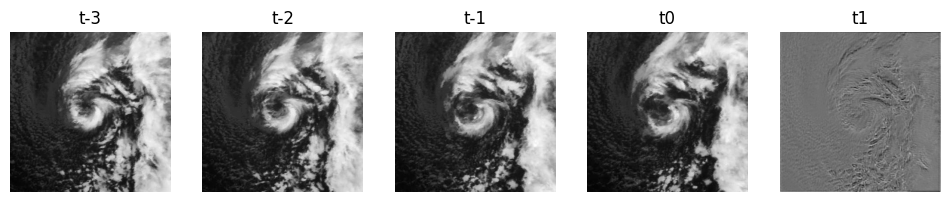

In [84]:
# plot a batch
BATCH_NUM = 1
C = 0  # only 1 channel

fig, axs = plt.subplots(
    1, INPUT_SEQUENCE_LENGTH + TARGET_SEQUENCE_LENGTH, figsize=(12, 12)
)
for _col in range(INPUT_SEQUENCE_LENGTH + TARGET_SEQUENCE_LENGTH):
    if _col < INPUT_SEQUENCE_LENGTH:
        axs[_col].imshow(
            img_seq[BATCH_NUM, _col - INPUT_SEQUENCE_LENGTH, C, :, :], cmap="gray"
        )
        axs[_col].set_title(f"t{_col-(INPUT_SEQUENCE_LENGTH)+1}")
        axs[_col].axis("off")
    else:
        # plotting predicted image
        axs[_col].imshow(
            _test_output[BATCH_NUM, 0, C, :, :].detach().cpu(), cmap="gray"
        )
        axs[_col].set_title(f"t{_col-(INPUT_SEQUENCE_LENGTH)+1}")
        axs[_col].axis("off")

In [86]:
# # plot the targets...
# # plot a batch
# BATCH_NUM = 1
# C = 0  # only 1 channel

# fig, axs = plt.subplots(
#     2, TARGET_SEQUENCE_LENGTH, figsize=(8, 8)
# )
# for _row in range(TARGET_SEQUENCE_LENGTH):
#     for _col in range(TARGET_SEQUENCE_LENGTH):
#         if _row == 0:
#             axs[_row, _col].imshow(
#                 target_seq[BATCH_NUM, _col - TARGET_SEQUENCE_LENGTH, C, :, :], cmap="gray"
#             )
#             axs[_row, _col].set_title(f"t+{_col+1}")
#             axs[_row, _col].axis("off")
#         else:
#             # plot predictions.
#             # plotting predicted image
#             axs[_row, _col].imshow(
#                 _test_output[BATCH_NUM, _col, C, :, :].detach().cpu(), cmap="gray"
#             )
#             axs[_row, _col].set_title(f"t+{_col+1}")
#             axs[_row, _col].axis("off")

In [87]:
## Testing VGG loss

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn import functional as F

"""A VGG-based perceptual loss function for PyTorch."""


class VGGLoss(nn.Module):
    """Computes the VGG perceptual loss between two batches of images.

    The input and target must be 4D tensors with three channels
    ``(B, 3, H, W)`` and must have equivalent shapes. Pixel values should be
    normalized to the range 0–1.

    The VGG perceptual loss is the mean squared difference between the features
    computed for the input and target at layer :attr:`layer` (default 8, or
    ``relu2_2``) of the pretrained model specified by :attr:`model` (either
    ``'vgg16'`` (default) or ``'vgg19'``).

    If :attr:`shift` is nonzero, a random shift of at most :attr:`shift`
    pixels in both height and width will be applied to all images in the input
    and target. The shift will only be applied when the loss function is in
    training mode, and will not be applied if a precomputed feature map is
    supplied as the target.

    :attr:`reduction` can be set to ``'mean'``, ``'sum'``, or ``'none'``
    similarly to the loss functions in :mod:`torch.nn`. The default is
    ``'mean'``.

    :meth:`get_features()` may be used to precompute the features for the
    target, to speed up the case where inputs are compared against the same
    target over and over. To use the precomputed features, pass them in as
    :attr:`target` and set :attr:`target_is_features` to :code:`True`.

    Instances of :class:`VGGLoss` must be manually converted to the same
    device and dtype as their inputs.
    """

    models = {"vgg16": models.vgg16, "vgg19": models.vgg19}

    def __init__(self, model="vgg16", layer=8, shift=0, reduction="mean"):
        super().__init__()
        self.shift = shift
        self.reduction = reduction
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        self.model = self.models[model](weights=True).features[: layer + 1]
        self.model.eval()
        self.model.requires_grad_(False)

    def get_features(self, input):
        return self.model(self.normalize(input))

    def train(self, mode=True):
        self.training = mode

    def forward(self, input, target, target_is_features=False):
        if target_is_features:
            input_feats = self.get_features(input)
            target_feats = target
        else:
            sep = input.shape[0]
            batch = torch.cat([input, target])
            if self.shift and self.training:
                padded = F.pad(batch, [self.shift] * 4, mode="replicate")
                batch = transforms.RandomCrop(batch.shape[2:])(padded)
            feats = self.get_features(batch)
            input_feats, target_feats = feats[:sep], feats[sep:]
        return F.mse_loss(input_feats, target_feats, reduction=self.reduction)

In [88]:
criterion_vgg = VGGLoss(
    shift=0, reduction="mean", model="vgg16"  # normalisation term
).to(
    DEVICE
)  # this needs to be sent to device.

/Users/ds423/miniconda3/envs/seqmod/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
# lets do some training....
KERNEL_SIZE = (3, 3)
INPUT_DIMS = (1, 366, 366)  # C, H, W
HIDDEN_CHANNELS = [2]
OUTPUT_CHANNELS = 1
NUM_LAYERS = 1
OUTPUT_SEQUENCE_LENGTH = 1

model = ConvLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
    input_dims=INPUT_DIMS,
    hidden_channels=HIDDEN_CHANNELS,
    output_channels=OUTPUT_CHANNELS,
    num_layers=NUM_LAYERS,
    kernel_size=KERNEL_SIZE,
    bias=True,
    apply_batchnorm=True,
    device=DEVICE,
    _print=False,
)

model = model.to(DEVICE)

optimiser = optim.Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction="sum")

model

ConvLSTMModel(
  (convlstm): ConvLSTM(
    (conv_lstm_cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv_input_and_hidden): Sequential(
          (conv_layer): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (conv_hidden_to_output): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [90]:
EPOCHS = 1
C = 3  # channels required for VGG

LOSS = "pixel"

train_losses, val_losses = [], []
for i in range(EPOCHS):
    # training
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for _, (X, y) in enumerate(tepoch):
            X, y = X.to(DEVICE), y.to(DEVICE)

            optimiser.zero_grad()

            output = model(X)

            if LOSS == "vgg":
                # convert prediction and label to 3 channels
                output3d = torch.cat([output[:, 0, :, :] for _ in range(C)], axis=1)
                target3d = torch.cat([y[:, 0, :, :, :] for _ in range(C)], axis=1)
                loss = criterion_vgg(output3d, target3d)
            else:
                loss = criterion(output.flatten(), y.flatten())

            loss.backward()

            train_loss += loss.item()
            optimiser.step()

            tepoch.set_postfix(batch_loss=loss.item())
    train_losses.append(train_loss / len(train_loader.dataset))

    # validation
    model.eval()
    val_loss = 0
    with tqdm(val_loader, unit="batch") as tepoch:
        with torch.no_grad():
            for _, (X, y) in enumerate(tepoch):
                X, y = X.to(DEVICE), y.to(DEVICE)
                output = model(X)

                if LOSS == "vgg":
                    # convert prediction and label to 3 channels
                    output3d = torch.cat([output[:, 0, :, :] for _ in range(C)], axis=1)
                    target3d = torch.cat([y[:, 0, :, :, :] for _ in range(C)], axis=1)
                    loss = criterion_vgg(output3d, target3d)
                else:
                    loss = criterion(output.flatten(), y.flatten())

                val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader.dataset))

100%|██████████| 67/67 [00:00<00:00, 73.12batch/s]


In [ ]:
# plot losses and accuracies
fig, ax = plt.subplots(figsize=(6, 6))

# training
add_metric_plot(
    axes=ax,
    X=np.arange(1, len(train_losses) + 1, 1),
    y=train_losses,
    legend="training loss",
    colour="C0",
)

# training
add_metric_plot(
    axes=ax,
    X=np.arange(1, len(val_losses) + 1, 1),
    y=val_losses,
    legend="val loss",
    colour="C1",
)

# plot config
ax.set_title("Training & Validation Losses.", fontsize=12)
ax.legend(loc="best")

In [ ]:
# basic inference
val_batch = next(iter(val_loader))
_img_seq, _target_seq = val_batch
C = 0  # single channel

# generate single next image from a sequence
pred_img = model(_img_seq.to(DEVICE))

fig, axs = plt.subplots(
    nrows=BATCH_SIZE, ncols=(INPUT_SEQUENCE_LENGTH + 1), figsize=(32, 20)
)
for r in range(axs.shape[0]):
    for c in range(axs.shape[-1]):
        if c <= (INPUT_SEQUENCE_LENGTH - 1):
            axs[r, c].imshow(_img_seq[r, c, 0, :, :].detach().cpu(), cmap="gray")
            axs[r, c].set_title(
                f"Image Sequence Num = {INPUT_SEQUENCE_LENGTH - c}", fontsize=12
            )
        else:
            axs[r, c].imshow(pred_img[r, -1:, 0, :, :][C].detach().cpu(), cmap="gray")
            axs[r, c].set_title("t+1...", fontsize=16)

        axs[r, c].axis("off")

plt.tight_layout()

### END OF SCRIPT